In [1]:
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, BatchNormalization, Input, Dropout, Activation, concatenate, GRU, Dropout
import keras.backend as K
from keras.optimizers import Adam, Nadam, SGD
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
import os, sys, time, threading
import tensorflow as tf
import numpy as np
import pandas as pd
# Disable depreciation warnings and limit verbosity during training
from tensorflow.python.util import deprecation

In [3]:
X = pd.read_pickle("input/X_HB.pkl")
X.drop(['PU','pt'],1,inplace=True)
mu,std = np.mean(X, axis=0), np.std(X, axis=0)
X = (X-mu)/std
X = pd.concat([X]*20, ignore_index=True)
Y = pd.read_pickle("input/Y_HB.pkl")[:][['genE']]


In [4]:
RATE = 0.001
NUM_EPOCHS = 11
VALSPLIT = 0.0
np.random.seed(5)
TRAIN_BATCH_SIZE = 2024

In [5]:
MODEL_DIR = 'gs://harrisgroup-ctpu/facile/model/'
DATA_DIR = 'gs://harrisgroup-ctpu/facile/data/'
TPU_NAME='uw-tpu'
ZONE_NAME='us-central1-b'
PROJECT_NAME = 'harrisgroup-223921'
NUM_ITERATIONS = 1000 # Number of iterations per TPU training loop
TRAIN_STEPS = 5000
NUM_SHARDS = 8 # Number of shards (TPU chips).
USE_TPU = True

lock = threading.Lock()

#tf.enable_eager_execution()

# DEFINE THE NETWORK

class ModelFacile(object):
    def __call__(self, inputs):
        net = tf.layers.dropout(inputs, rate = 0.001)
        net = tf.layers.dense(net, 36, activation = 'relu')
        norm = tf.layers.dropout(net, rate = 0.001)
        net = tf.layers.dense(norm, 11, activation = 'relu')
        norm = tf.layers.dropout(net, rate = 0.001)
        net = tf.layers.dense(norm, 3, activation = 'relu')
        return tf.layers.dense(net, 1, activation = 'linear', name='output')

def model_fn(features, labels, mode, params):
    model = ModelFacile()

    if mode == tf.estimator.ModeKeys.PREDICT:
        predicted_values = model(features)
        predictions = {
            'probabilities': predicted_values,
        }
        return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=predictions)


# CREATE AND PREDICT WITH TPUS

def create_estimator(batch_size):
    print("Creating the estimator")
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
        TPU_NAME,
        zone=ZONE_NAME,
        project=PROJECT_NAME)

    run_config = tf.contrib.tpu.RunConfig(
        cluster=tpu_cluster_resolver,
        model_dir=MODEL_DIR,
        session_config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True),
        tpu_config=tf.contrib.tpu.TPUConfig(NUM_ITERATIONS, NUM_SHARDS))
    
    estimator = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=USE_TPU,
        train_batch_size=batch_size,
        eval_batch_size=batch_size,
        predict_batch_size=batch_size,
        params={"data_dir": DATA_DIR},
        config=run_config,
        warm_start_from = tf.compat.v1.estimator.WarmStartSettings(ckpt_to_initialize_from=
                                                                   "gs://harrisgroup-ctpu/facile/model/",
                                                                  vars_to_warm_start=".*"))
    return estimator

def predict(data, batch_size,estimator, results=None, times=None, job_id=None):
    assert (results is None and times is None and job_id is None) or not (results is None or times is None or job_id is None)
    #lock.acquire()
    

    print("Predicting")
    def predict_input_fn(params):
        batch_size = params["batch_size"]
        dataset_predict = tf.data.Dataset.from_tensor_slices(data.astype('float32'))
        return dataset_predict.batch(batch_size)
    
    predictions = estimator.predict(predict_input_fn)
    
    num_print = 10
    num = 0
    predicted_values = []
    start_time = time.time()
    for pred_dict in predictions:
        predicted_values.append(list(pred_dict.values())[0][0])
        num += 1
        if (num >= num_print):
            break
            
    print(predicted_values[:10])

    predict_time = time.time() - start_time
    #lock.release()

    return predict_time

In [6]:
tf.logging.set_verbosity(tf.logging.INFO)


Creating the estimator

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_tf_random_seed': None, '_num_worker_replicas': 1, '_eval_distribute': None, '_log_step_count_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=2, tpu_job_name=None, initial_infeed_sleep_secs=None, input_partition_dims=None), '_protocol': None, '_device_fn': None, '_train_distribute': None, '_num_ps_replicas': 0, '_model_dir': 'gs://harrisgroup-ctpu/facile/model/', '_keep_checkpoint_max': 5, '_task_id': 0, '_task_type': 'worker', '_save_summary_steps': 100, '_service': None, '_session_config': allow_soft_placement: true
log_device_placement: true

Exception ignored in: <generator object TPUEstimator.predict at 0x7f2b94464d58>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/tpu/python/tpu/tpu_estimator.py", line 2500, in predict
    rendezvous.raise_errors()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/tpu/python/tpu/error_handling.py", line 132, in raise_errors
    six.reraise(typ, value, traceback)
  File "/home/nsuaysom/.local/lib/python3.5/site-packages/six.py", line 696, in reraise
    raise value
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/tpu/python/tpu/error_handling.py", line 101, in catch_errors
    yield
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/tpu/python/tpu/tpu_estimator.py", line 478, in _run_infeed
    session.run(self._enqueue_ops)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 929, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.5/dist-pack

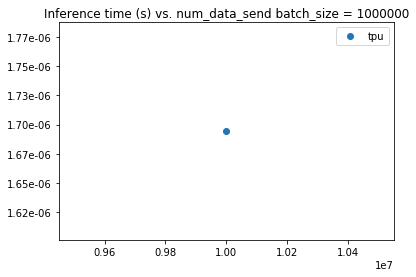

[1.694461965560913e-06]


In [7]:
time_list = []
tf.logging.set_verbosity(tf.logging.INFO)
#tf.logging.set_verbosity(tf.logging.FATAL)
BATCH_SIZE = 1000000
#estimator = create_estimator(int(BATCH_SIZE))
num_data_list = [int(1e7)]
for N in num_data_list:
    estimator = create_estimator(int(N/8))
    start_time = time.time()
    predict(X[:N],1,estimator)
    time_in_s = time.time() - start_time
    print("Time used in the prediction is " + str(time_in_s) + " batch_size = " + str(BATCH_SIZE) + " num_data = " + str(N))
    time_list.append(time_in_s/N)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(num_data_list), time_list, 'o', label = 'tpu')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.legend()
plt.title("Inference time (s) vs. num_data_send batch_size = " + str(BATCH_SIZE))
plt.show()
print(time_list)

In [15]:
np.set_printoptions(precision=3)
print(np.array(Y["genE"][:10]))

[ 0.415  1.178 31.989  0.206  4.094  4.966  0.356 21.954  3.917  0.178]


In [136]:
3e5

300000.0

In [ ]:
(0.00019141989707946778*600000-27)/600000

In [ ]:
[13.894327163696289/1000, 41.09413719177246/10000, 149.68007469177246/100000, 642.9999010562897/600000]

In [ ]:
predicted_values

1. TRAIN_STEPS*TRAIN_BATCH_SIZE < len(X)
2. Wrong learning rate kills everything

In [ ]:
print(result[:10])